## Import the required modules, classes methods 

In [90]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt     
import seaborn as sns; sns.set()
from matplotlib import MatplotlibDeprecationWarning
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)
warnings.simplefilter('ignore', category=UserWarning)

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
from sklearn.ensemble import ExtraTreesClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression



## Assembling the data set

### Oscars' data

In [91]:
oscars = pd.read_csv('the_oscar_award.csv') #reading the data from csv

In [92]:
print(oscars.head())
print(oscars['year_film'].min())
print(oscars['year_film'].max())

   year_film  year_ceremony  ceremony category                 name  \
0       1927           1928         1    ACTOR  Richard Barthelmess   
1       1927           1928         1    ACTOR        Emil Jannings   
2       1927           1928         1  ACTRESS       Louise Dresser   
3       1927           1928         1  ACTRESS         Janet Gaynor   
4       1927           1928         1  ACTRESS       Gloria Swanson   

               film winner  
0         The Noose  False  
1  The Last Command   True  
2   A Ship Comes In  False  
3        7th Heaven   True  
4    Sadie Thompson  False  
1927
2022


Cleaning the film title and year fields to enable matching with other data sets. 

In [93]:
pattern = r'[!"#$%&\'()*+, -.\/:;<=>?@[\]^_`{|}~]+' #cleaning the film titles of punctuation and making them uppercase
oscars['film'] = oscars['film'].str.upper()
oscars['film'] = oscars['film'].str.replace(pattern,'',regex = True)
oscars.drop(oscars[oscars.year_film > 2017].index,inplace=True) #dropping all values after year 2017 

Creating a new dataframe to sum the wins and nominations per film. 

In [94]:
oscars_film = oscars['film'].unique() #listing the unique film titles
oscars_count = pd.DataFrame(columns = ['film','wins','nominations']) #creating the new dataframe
oscars_count['film']= oscars_film #filling in the film column of df 
films = oscars_count['film'].tolist()
wins = []
nominations = []
for film in films: #looping over the film list to count wins and noms per film
    count_of_wins = len(oscars[(oscars['film']==film) & (oscars['winner']==True)])
    wins += [count_of_wins]
    count_of_noms = len(oscars[(oscars['film']==film) & (oscars['winner']==False)]) #winner column is false for nominees
    nominations += [count_of_noms]
oscars_count['wins'] = wins #filling in the dataframe
oscars_count['nominations']=nominations


In [95]:
oscars_years = oscars.copy() #making a list of just the film years alongside title, year is important to join correct film data
oscars_years.drop(columns = ['year_ceremony','ceremony','category','name','winner'],inplace = True)
oscars_years.rename(columns={'year_film': 'year'}, inplace = True )
oscars_years.head()

,year,film
0,1927,THENOOSE
1,1927,THELASTCOMMAND
2,1927,ASHIPCOMESIN
3,1927,7THHEAVEN
4,1927,SADIETHOMPSON


In [96]:
oscars_all = pd.merge(oscars_count,oscars_years,on = 'film') #merging the count dataframe with the film release years

In [97]:
oscars_all.rename(columns={'film': 'title'}, inplace=True) #changing the column to align with other dataframes

In [98]:
oscars_all.drop_duplicates(subset=['title'],inplace=True,ignore_index = True)

In [99]:
len(oscars_all)

4724

### Bechdel Data

In [100]:
bechdel = pd.read_csv('Bechdel.csv') #reading data from CSV

In [101]:
print(bechdel['year'].min())
print(bechdel['year'].max())

1874
2021


In [102]:
bechdel.drop(columns = ['imdbid','id','Unnamed: 0'], inplace = True) #dropping id columns which are unique and unnamed extra index column

In [103]:
bechdel.drop(bechdel[bechdel.year > 2017].index,inplace=True)#dropping all values before 1927 and after 2017
bechdel.drop(bechdel[bechdel.year < 1927].index,inplace=True) 

In [104]:
bechdel['title'] = bechdel['title'].str.upper() #cleaning the film titles to be able to join with other datasets
bechdel['title'] = bechdel['title'].str.replace(pattern,'',regex = True)

In [105]:
bechdel.rename(columns={'rating': 'bechdel_rating'}, inplace=True) #renaming the column to make the meaning clearer

In [106]:
len(bechdel)

8446

### Movie database data

In [107]:
tmdb_credits = pd.read_csv('tmdb_5000_credits.csv') #reading credits data from csv

In [108]:
tmdb_credits.drop(columns=['movie_id'],inplace=True) #dropping the column 

Using the data from this 'credits' data set to create a new data frame featuring percentages of the cast and crew who identify as female. 

In [109]:
def proportion_rep(column):#function to create percentages
    for i in range(len(column)):
        list_of_people = column[i]
        list_of_people = json.loads(list_of_people)#lists of cast and crew are stored in json format
        female = 0
        male = 0 
        for cast_dict in list_of_people:
            if cast_dict['gender']==1:#gender 0 is unconfirmed, gender 1 is female, gender 2 is male
                female+=1
            elif cast_dict['gender']==2:
                male+=1
        try:
            column[i]= round((female/(female+male)*100),2)
        except ZeroDivisionError:
            column[i]= 100
    return column

In [110]:
newcast = proportion_rep(tmdb_credits['cast']) #calling the function to create proportions
newcrew = proportion_rep(tmdb_credits['crew'])
tmdb_credits.rename(columns={'cast': 'prop_female_cast','crew':'prop_female_crew'},inplace=True) #renaming the features for clarity

In [111]:
tmdb_movies = pd.read_csv('tmdb_5000_movies.csv') #reading the other movie data

In [112]:
tmdb_movies.drop(columns = ['homepage','id','genres','keywords','original_language','original_title','overview','production_companies','production_countries','spoken_languages','status','tagline'],inplace=True)

In [113]:
tmdb_movies['release_date']= tmdb_movies['release_date'].str.extract(r'([0-9]+)',expand=False) #cleaning data to extract release year to enable matching of films
tmdb_movies['release_date'] = tmdb_movies['release_date'].fillna(2015) #filling the singular NaN value with a value manually found on Google for that film 
tmdb_movies['release_date']= tmdb_movies['release_date'].astype(int)
tmdb_movies.rename(columns={'release_date': 'year'}, inplace=True)

In [114]:
tmdb_both = pd.merge(tmdb_movies,tmdb_credits,on = 'title',how='outer') #merging the credits proportions with the other movie data

In [115]:
tmdb_both.drop(tmdb_both[tmdb_both.year < 1927].index,inplace=True) #dropping all values before year 1927 to align with other datasets

In [116]:
tmdb_both['title'] = tmdb_both['title'].str.upper() #cleaning the film titles to be able to join with other datasets
tmdb_both['title'] = tmdb_both['title'].str.replace(pattern,'',regex = True)

In [117]:
len(tmdb_both)

4807

### Assembling the three datasets

In [118]:
film_data = tmdb_both.merge(oscars_all,how='outer',on=['title','year'])

In [119]:
film_data = film_data.merge(bechdel,how='outer',on =['title','year'])

In [120]:
film_data.head()

,budget,popularity,year,revenue,runtime,title,vote_average,vote_count,prop_female_cast,prop_female_crew,wins,nominations,bechdel_rating
0,237000000.0,150.437577,2009,2.787965e+09,162.0,AVATAR,7.2,11800.0,37.5,26.32,3.0,6.0,3.0
1,300000000.0,139.082615,2007,9.610000e+08,169.0,PIRATESOFTHECARIBBEANATWORLDSEND,6.9,4500.0,16.67,34.78,0.0,2.0,NaN
2,245000000.0,107.376788,2015,8.806746e+08,148.0,SPECTRE,6.3,4466.0,19.12,13.79,1.0,0.0,1.0
3,250000000.0,112.312950,2012,1.084939e+09,165.0,THEDARKKNIGHTRISES,7.6,9106.0,13.1,11.9,NaN,NaN,NaN
4,260000000.0,43.926995,2012,2.841391e+08,132.0,JOHNCARTER,6.1,2124.0,24.0,16.67,NaN,NaN,3.0


In [121]:
len(film_data)

14670

## Exploring the data

### Looking at the size of the data and variables

In [122]:
film_data.columns

Index(['budget', 'popularity', 'year', 'revenue', 'runtime', 'title',
       'vote_average', 'vote_count', 'prop_female_cast', 'prop_female_crew',
       'wins', 'nominations', 'bechdel_rating'],
      dtype='object')

In [123]:
film_data.dtypes

budget              float64
popularity          float64
year                  int64
revenue             float64
runtime             float64
title                object
vote_average        float64
vote_count          float64
prop_female_cast     object
prop_female_crew     object
wins                float64
nominations         float64
bechdel_rating      float64
dtype: object

In [124]:
film_data.shape

(14670, 13)

In [125]:
film_data['prop_female_cast']=film_data['prop_female_cast'].astype(float)
film_data['prop_female_crew']=film_data['prop_female_crew'].astype(float)

### Preliminary exploration of values in the data

In [126]:
film_data.isnull().sum() #looking for NaN or None values 

budget              9862
popularity          9862
year                   0
revenue             9862
runtime             9864
title                  1
vote_average        9862
vote_count          9862
prop_female_cast    9862
prop_female_crew    9862
wins                9941
nominations         9941
bechdel_rating      6223
dtype: int64

In [127]:
film_data.describe()

,budget,popularity,year,revenue,runtime,vote_average,vote_count,prop_female_cast,prop_female_crew,wins,nominations,bechdel_rating
count,4.808000e+03,4808.000000,14670.000000,4.808000e+03,4806.000000,4808.000000,4808.000000,4808.000000,4808.000000,4729.000000,4729.000000,8447.000000
mean,2.904411e+07,21.509005,1990.589707,8.233018e+07,106.858094,6.091951,690.801997,34.538257,23.589434,0.430746,1.655107,2.138156
std,4.070587e+07,31.810626,24.461209,1.628599e+08,22.559996,1.193913,1234.322087,19.882020,25.949203,1.022129,1.621978,1.086359
min,0.000000e+00,0.000000,1927.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000e+05,4.677382,1975.000000,0.000000e+00,94.000000,5.600000,54.000000,21.210000,0.000000,0.000000,1.000000,1.000000
50%,1.500000e+07,12.928897,2000.000000,1.917498e+07,103.000000,6.200000,236.000000,33.330000,18.180000,0.000000,1.000000,3.000000
75%,4.000000e+07,28.351574,2010.000000,9.293886e+07,118.000000,6.800000,738.000000,45.450000,31.820000,1.000000,2.000000,3.000000
max,3.800000e+08,875.581305,2017.000000,2.787965e+09,338.000000,10.000000,13752.000000,100.000000,100.000000,12.000000,15.000000,3.000000


Creating the binary 'has_oscar' field to replace the wins and nominations features. 

In [128]:
film_data['has_oscar'] = np.where((film_data['wins']>0)|(film_data['nominations']>0),1,0) #generating a binary 'has_oscar' field for categorisation
film_data.drop(columns=['wins','nominations'],inplace=True)

## Missing value imputation

#### Dealing with the null values before exploring distributions of the data, since there are so many null values. 

Calculating the proportion of genuine data. 

In [129]:
def proportion_of_values(columns): #function to calculate the percentage of data that is not 0 or null
    column_names = list(columns) 
    zeroes ={}
    values = {}
    proportion_w_value = {}
    for variable in column_names:
        zero_values = len(film_data[(film_data[variable]==0)|(film_data[variable].isna())].index)
        if zero_values>0:
            zeroes[variable] = zero_values
        full_values = len(film_data[(film_data[variable]!=0)&(film_data[variable].notnull())].index)
        if full_values>0:
            values[variable] = full_values
    for column in column_names:
        try:
            proportion_w_value[column]= round((values[column]/(values[column]+zeroes[column]))*100,2)
        except KeyError:
            proportion_w_value[column]= 100
    return proportion_w_value

In [130]:
proportion_of_values(film_data.columns) #call the function to see proportion of genuine data

{'budget': 25.69,
 'popularity': 32.77,
 'year': 100,
 'revenue': 23.03,
 'runtime': 32.52,
 'title': 99.99,
 'vote_average': 32.34,
 'vote_count': 32.35,
 'prop_female_cast': 31.27,
 'prop_female_crew': 23.88,
 'bechdel_rating': 51.78,
 'has_oscar': 32.23}

Proportion of genuine values is low among many features. Aiming to preserve as many target variable values as possible.

In [131]:
film_data[(film_data['revenue'].isna())]

,budget,popularity,year,revenue,runtime,title,vote_average,vote_count,prop_female_cast,prop_female_crew,bechdel_rating,has_oscar
4808,NaN,NaN,1927,NaN,NaN,THENOOSE,NaN,NaN,NaN,NaN,NaN,1
4809,NaN,NaN,1927,NaN,NaN,THELASTCOMMAND,NaN,NaN,NaN,NaN,NaN,1
4810,NaN,NaN,1927,NaN,NaN,ASHIPCOMESIN,NaN,NaN,NaN,NaN,NaN,1
4811,NaN,NaN,1927,NaN,NaN,7THHEAVEN,NaN,NaN,NaN,NaN,NaN,1
4812,NaN,NaN,1927,NaN,NaN,SADIETHOMPSON,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...
14665,NaN,NaN,2017,NaN,NaN,NOVITIATE,NaN,NaN,NaN,NaN,2.0,0
14666,NaN,NaN,2017,NaN,NaN,LANDLINE,NaN,NaN,NaN,NaN,3.0,0
14667,NaN,NaN,2017,NaN,NaN,FEMALEBRAINTHE,NaN,NaN,NaN,NaN,3.0,0
14668,NaN,NaN,2017,NaN,NaN,BARBIEVIDEOGAMEHERO,NaN,NaN,NaN,NaN,1.0,0


In [132]:
# delete NaN value instances which are not Oscar nominated or winners
film_data.drop(film_data[(film_data['has_oscar']==0)&(film_data['revenue'].isna())].index,inplace=True) 

In [133]:
film_data.shape # still shows a lot of values preserved, not sufficiently rebalanced

(8683, 12)

In [134]:
# delete NaN value instances which are Oscar nominated or winning 
film_data.drop(film_data[(film_data['has_oscar']>0)&(film_data['revenue'].isnull())].index,inplace=True)

In [135]:
len(film_data[film_data['revenue'].notnull()].index)

4808

In [136]:
proportion_of_values(film_data.columns) 

{'budget': 78.39,
 'popularity': 99.98,
 'year': 100,
 'revenue': 70.26,
 'runtime': 99.23,
 'title': 100,
 'vote_average': 98.69,
 'vote_count': 98.71,
 'prop_female_cast': 95.4,
 'prop_female_crew': 72.86,
 'bechdel_rating': 38.62,
 'has_oscar': 17.74}

Dealing with remaining NaN and 0 values by replacing with the mean and median, where appropriate.

In [137]:
# inspecting the number of 0 values in each feature
column_names = list(film_data.columns) 
zeroes ={}
for variable in column_names:
    zero_values = len(film_data[film_data[variable]==0])
    if zero_values>0:
        zeroes[variable] = zero_values
print(zeroes)

{'budget': 1039, 'popularity': 1, 'revenue': 1430, 'runtime': 35, 'vote_average': 63, 'vote_count': 62, 'prop_female_cast': 221, 'prop_female_crew': 1305, 'bechdel_rating': 147, 'has_oscar': 3955}


In [138]:
#replace with mean/median depending on variance in feature
#proportions, oscars and bechdel ratings could have genuine 0 values
replacing_mean = ['popularity','runtime','vote_average','vote_count']
replacing_median = ['budget','revenue']
for column in replacing_mean:
    film_data[column].replace(0,np.nan,inplace=True) #replacing false 0 with NaN to create true mean
    film_data[column].fillna(film_data[column].mean(),inplace=True) 
for column in replacing_median:
    film_data[column].replace(0,np.nan,inplace=True)
    film_data[column].fillna(film_data[column].median(),inplace=True)

In [139]:
# filling in NaN values for columns which are likely to contain genuine 0 values
true_0_columns= ['prop_female_cast','prop_female_crew','bechdel_rating'] 
for column in true_0_columns:
    film_data[column].fillna(0,inplace=True)

In [140]:
proportion_of_values(film_data.columns) 

{'budget': 100,
 'popularity': 100,
 'year': 100,
 'revenue': 100,
 'runtime': 100,
 'title': 100,
 'vote_average': 100,
 'vote_count': 100,
 'prop_female_cast': 95.4,
 'prop_female_crew': 72.86,
 'bechdel_rating': 38.62,
 'has_oscar': 17.74}

In [141]:
film_data.describe() # checking on the data post processing

,budget,popularity,year,revenue,runtime,vote_average,vote_count,prop_female_cast,prop_female_crew,bechdel_rating,has_oscar
count,4.808000e+03,4808.000000,4808.000000,4.808000e+03,4808.000000,4808.000000,4808.000000,4808.000000,4808.000000,4808.000000,4808.000000
mean,3.401437e+07,21.513480,2002.496464,9.775680e+07,107.642004,6.172835,699.826380,34.538257,23.589434,0.881656,0.177413
std,3.818148e+07,31.809113,12.313700,1.566683e+08,20.615334,0.965706,1231.793674,19.882020,25.949203,1.243386,0.382057
min,1.000000e+00,0.000372,1927.000000,5.000000e+00,14.000000,0.500000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.200000e+07,4.682212,1999.000000,2.764204e+07,94.000000,5.600000,59.000000,21.210000,0.000000,0.000000,0.000000
50%,2.300000e+07,12.939076,2005.000000,5.186794e+07,104.000000,6.200000,251.000000,33.330000,18.180000,0.000000,0.000000
75%,4.000000e+07,28.351574,2011.000000,9.293886e+07,118.000000,6.800000,738.000000,45.450000,31.820000,2.000000,0.000000
max,3.800000e+08,875.581305,2017.000000,2.787965e+09,338.000000,10.000000,13752.000000,100.000000,100.000000,3.000000,1.000000


In [142]:
initial_data = film_data.copy() #making a copy to show initial model results on imbalanced data

Dropping additional samples as the data is highly imbalanced and affects the model.

In [143]:
no_oscar = film_data[film_data['has_oscar']==0].copy() #splitting the data to delete mainly data which does not contain data in target variable
has_oscar = film_data[film_data['has_oscar']==1].copy()
no_oscar.drop(index=no_oscar.index[:2000],inplace=True)

In [144]:
film_data= pd.DataFrame() #concatenating the Oscar films with no Oscar films again
film_data = pd.concat([no_oscar,has_oscar]).reset_index(drop=True)

## Exploring the distribution of data

### Distribution of categorical variables

There are only two categorical variables: has_oscar and bechdel rating.

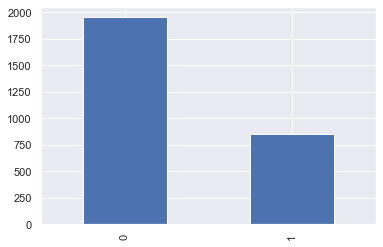

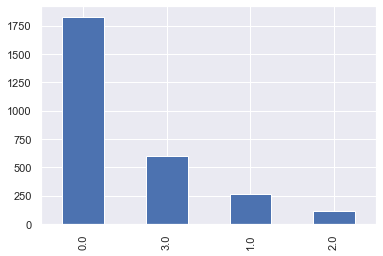

In [145]:
film_data['has_oscar'].value_counts().plot.bar() #counts of Oscar recognised films
plt.show()
film_data['bechdel_rating'].value_counts().plot.bar() #counts of Bechdel scores
plt.show()

### Distribution of continuous variables

The remaining variables are continuous variables: budget, popularity, year, revenue, runtime, title, vote_average, vote_count, prop_female_cast, prop_female_crew.

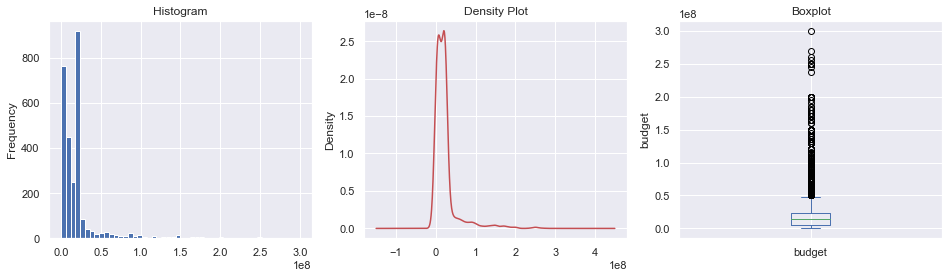

In [146]:
#budget distribution
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
film_data['budget'].plot(kind='hist', bins=50, ax=axes[0], xlabel="budget",
                           title="Histogram")
film_data['budget'].plot(kind='density', color='r', ax=axes[1], title='Density Plot')
film_data['budget'].plot(kind='box', ax=axes[2], ylabel='budget',
                           xlabel='', title='Boxplot')
plt.show()

<AxesSubplot:title={'center':'Boxplot'}, ylabel='vote_average'>

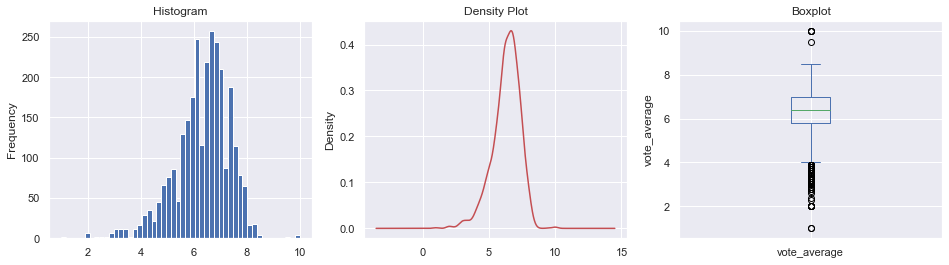

In [147]:
# average votes distribution
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
film_data['vote_average'].plot(kind='hist', bins=50, ax=axes[0], xlabel="vote_average",
                           title="Histogram")
film_data['vote_average'].plot(kind='density', color='r', ax=axes[1], title='Density Plot')
film_data['vote_average'].plot(kind='box', ax=axes[2], ylabel='vote_average',
                           xlabel='', title='Boxplot')

<AxesSubplot:title={'center':'Boxplot'}, ylabel='Revenue'>

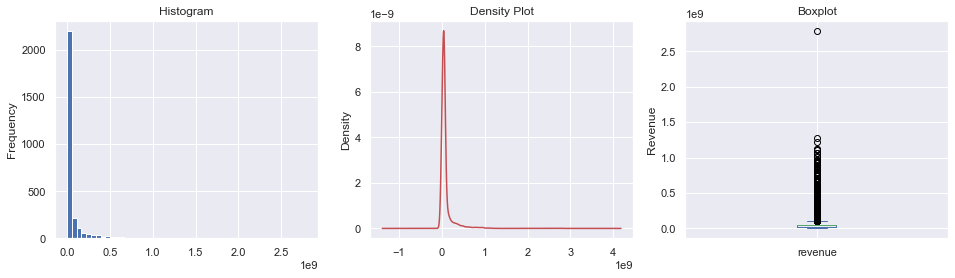

In [148]:
# revenue distribution
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
film_data['revenue'].plot(kind='hist', bins=50, ax=axes[0], xlabel="Revenue",
                           title="Histogram")
film_data['revenue'].plot(kind='density', color='r', ax=axes[1], title='Density Plot')
film_data['revenue'].plot(kind='box', ax=axes[2], ylabel='Revenue',
                           xlabel='', title='Boxplot')

<AxesSubplot:title={'center':'Boxplot'}, ylabel='prop_female_crew'>

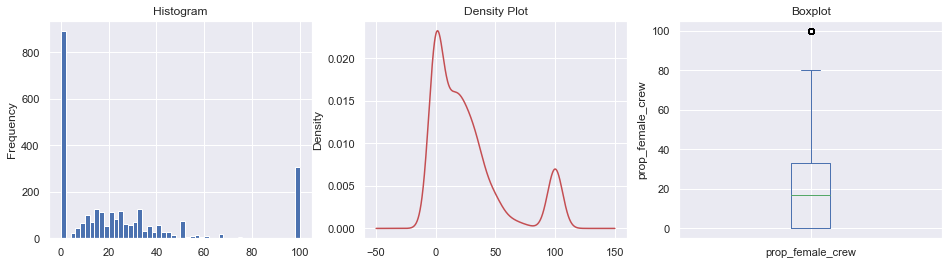

In [149]:
# proportion of female crew distribution
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
film_data['prop_female_crew'].plot(kind='hist', bins=50, ax=axes[0], xlabel="prop_female_crew",
                           title="Histogram")
film_data['prop_female_crew'].plot(kind='density', color='r', ax=axes[1], title='Density Plot')
film_data['prop_female_crew'].plot(kind='box', ax=axes[2], ylabel='prop_female_crew',
                           xlabel='', title='Boxplot')

<AxesSubplot:title={'center':'Boxplot'}, ylabel='popularity'>

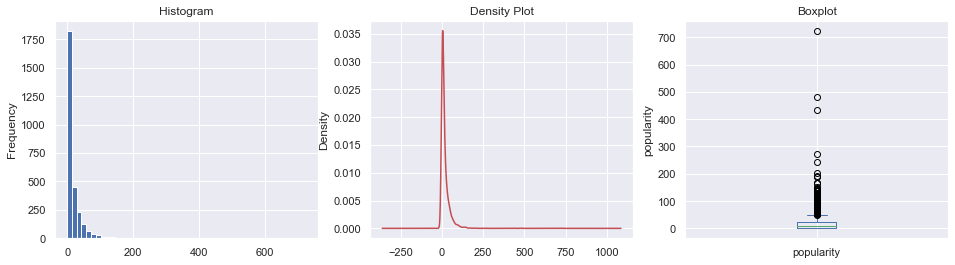

In [150]:
# popularity distribution
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
film_data['popularity'].plot(kind='hist', bins=50, ax=axes[0], xlabel="popularity",
                           title="Histogram")
film_data['popularity'].plot(kind='density', color='r', ax=axes[1], title='Density Plot')
film_data['popularity'].plot(kind='box', ax=axes[2], ylabel='popularity',
                           xlabel='', title='Boxplot')

<AxesSubplot:title={'center':'Boxplot'}, ylabel='prop_female_cast'>

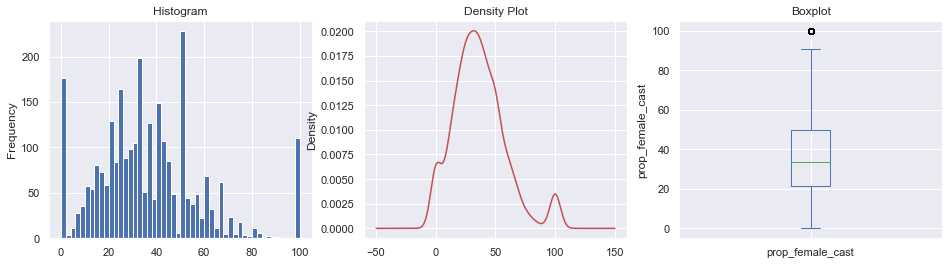

In [151]:
# proportion of female cast distribution
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
film_data['prop_female_cast'].plot(kind='hist', bins=50, ax=axes[0], xlabel="prop_female_cast",
                           title="Histogram")
film_data['prop_female_cast'].plot(kind='density', color='r', ax=axes[1], title='Density Plot')
film_data['prop_female_cast'].plot(kind='box', ax=axes[2], ylabel='prop_female_cast',
                           xlabel='', title='Boxplot')

## Biavariate Analysis

### Bechdel score (categorical variable) against Oscar status

Counts for Bechdel Rating vs Oscar Status are:
has_oscar          0    1
bechdel_rating           
0.0             1447  381
1.0              126  139
2.0               55   59
3.0              327  274

Normalised counts for Bechdel Rating vs Oscar Status are:
has_oscar              0         1
bechdel_rating                    
0.0             0.791575  0.208425
1.0             0.475472  0.524528
2.0             0.482456  0.517544
3.0             0.544093  0.455907


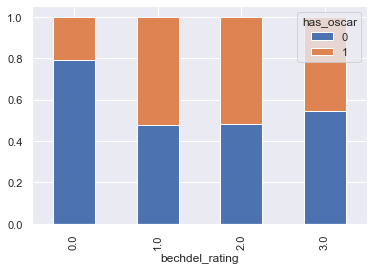

In [152]:
bechdel_rating=pd.crosstab(film_data['bechdel_rating'],film_data['has_oscar'])
print('Counts for Bechdel Rating vs Oscar Status are:\n{}'.format(bechdel_rating))

bechdel_rating = bechdel_rating.div(bechdel_rating.sum(1).astype(float), axis=0) #normalising the counts
print('\nNormalised counts for Bechdel Rating vs Oscar Status are:\n{}'.format(bechdel_rating))

bechdel_rating.plot(kind="bar", stacked=True) #plotting normalised values
plt.show()

### Analysis of continuous variables against Oscar status

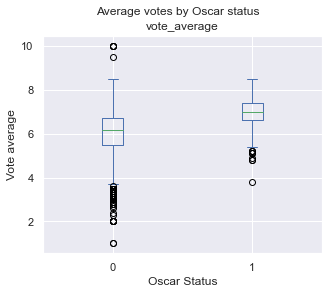

In [153]:
film_data.plot(column="vote_average", by='has_oscar', kind='box', subplots=False, 
        xlabel='Oscar Status', ylabel="Vote average", 
        title="Average votes by Oscar status", figsize=(5, 4))
plt.xlabel('Oscar Status')  
plt.show()

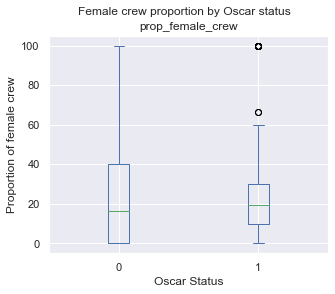

In [154]:
film_data.plot(column="prop_female_crew", by='has_oscar', kind='box', subplots=False, 
        xlabel='Oscar Status', ylabel="Proportion of female crew", 
        title="Female crew proportion by Oscar status", figsize=(5, 4))
plt.xlabel('Oscar Status')  
plt.show()

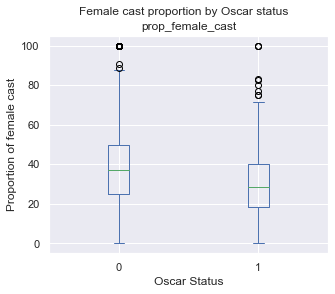

In [155]:
film_data.plot(column="prop_female_cast", by='has_oscar', kind='box', subplots=False, 
        xlabel='Oscar Status', ylabel="Proportion of female cast", 
        title="Female cast proportion by Oscar status", figsize=(5, 4))
plt.xlabel('Oscar Status') 
plt.show()

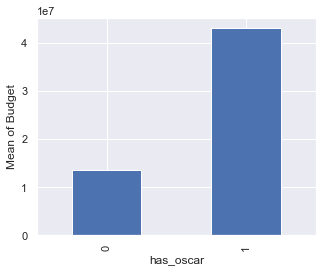

In [156]:
film_data.groupby('has_oscar')['budget'].mean().plot(kind='bar', 
                                                           ylabel='Mean of Budget',
                                                           figsize=(5, 4))
plt.show()

Discretised continuous variables against the target variable.

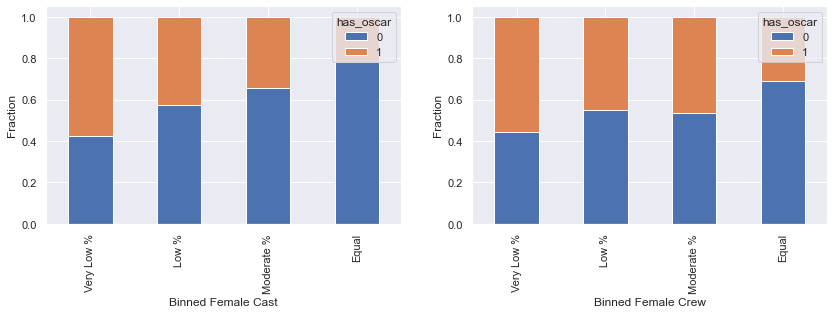

In [157]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

# Discretised Female Cast vs. Oscar Status

bins=[0,10,20,40,50]  # boundaries for the bins
labels=['Very Low %','Low %','Moderate %','Equal']  # names for the bins
film_data['female_cast_bin']=pd.cut(film_data['prop_female_cast'],bins,labels=labels) #  add discretised values as new column

female_cast_bin=pd.crosstab(film_data['female_cast_bin'],film_data['has_oscar'])  # get value combination counts
female_cast_bin = female_cast_bin.div(female_cast_bin.sum(1).astype(float), axis=0)  # normalise counts
female_cast_bin.plot(kind="bar",stacked=True, ax=axes[0], xlabel="Binned Female Cast", ylabel="Fraction")

# Discretised Female Crew vs. Oscar Status

bins = [0,10,20,40,50]  # boundaries for the bins
labels = ['Very Low %','Low %','Moderate %','Equal']  # names for the bins
film_data['female_crew_bin']=pd.cut(film_data['prop_female_crew'],bins,labels=labels)  # add discretised values as new column

female_crew_bin=pd.crosstab(film_data['female_crew_bin'],film_data['has_oscar']) # get value combination counts
female_crew_bin = female_crew_bin.div(female_crew_bin.sum(1).astype(float), axis=0)  # normalise counts
female_crew_bin.plot(kind="bar",stacked=True, ax=axes[1], xlabel="Binned Female Crew", ylabel="Fraction")

plt.show()

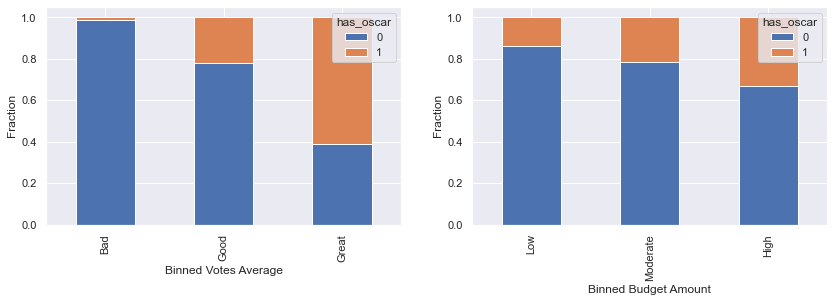

In [158]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

# Discretised Vote Average vs. Oscar Status

bins=[0,4,7,9]  # boundaries for the bins
labels=['Bad','Good','Great']  # names for the bins
film_data['votes_bin']=pd.cut(film_data['vote_average'],bins,labels=labels) #  add discretised values as new column

votes_bin=pd.crosstab(film_data['votes_bin'],film_data['has_oscar'])  # get value combination counts
votes_bin = votes_bin.div(votes_bin.sum(1).astype(float), axis=0)  # normalise counts
votes_bin.plot(kind="bar",stacked=True, ax=axes[0], xlabel="Binned Votes Average", ylabel="Fraction")

# Discretised Budget vs. Oscar Status

bins = [0,1000000,10000000,100000000]  # boundaries for the bins
labels = ['Low','Moderate','High']  # names for the bins
film_data['budget_bin']=pd.cut(film_data['budget'],bins,labels=labels)  # add discretised values as new column

budget_bin=pd.crosstab(film_data['budget_bin'],film_data['has_oscar']) # get value combination counts
budget_bin = budget_bin.div(budget_bin.sum(1).astype(float), axis=0)  # normalise counts
budget_bin.plot(kind="bar",stacked=True, ax=axes[1], xlabel="Binned Budget Amount", ylabel="Fraction")

plt.show()

## Pre-processing

### 3.1. Adjusting the distributions of continuous variables

N.B. Further pre-processing has already been carried out in missing value imputation.
<br>
<br>
From the initial exploration of the data, it is clear that budget, revenue and popularity should be adjusted, given their distributions.

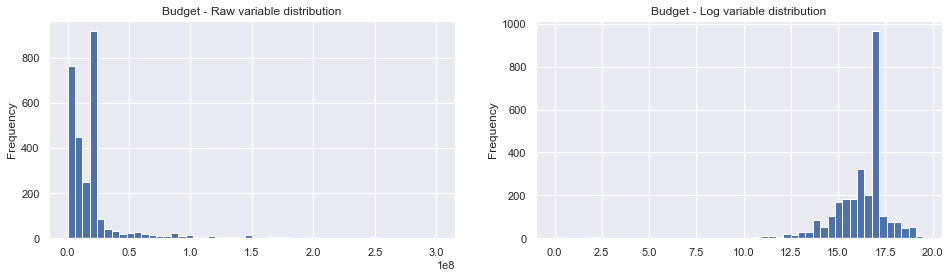

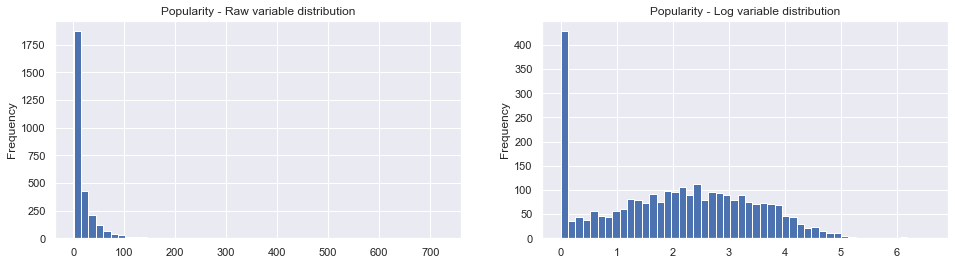

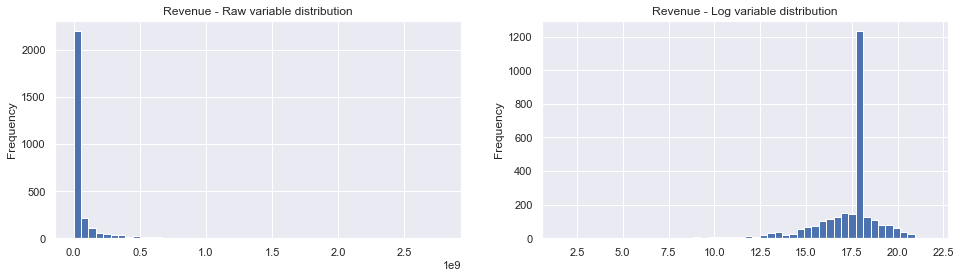

In [159]:
 # get the logarithmic scale of each variable not normally distributed
film_data['budgetlog'] = np.log(film_data['budget']) 
film_data['revenuelog'] = np.log(film_data['revenue'])
film_data['popularity'] = np.where((film_data['popularity']<1),1,film_data['popularity']) # not taking the log of 0
film_data['popularitylog'] = np.log(film_data['popularity'])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
film_data['budget'].plot(kind='hist', bins=50, ax=axes[0], title='Budget - Raw variable distribution')
film_data['budgetlog'].plot(kind='hist', bins=50, ax=axes[1], title='Budget - Log variable distribution')
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
film_data['popularity'].plot(kind='hist', bins=50, ax=axes[0], title='Popularity - Raw variable distribution')
film_data['popularitylog'].plot(kind='hist', bins=50, ax=axes[1], title='Popularity - Log variable distribution')
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
film_data['revenue'].plot(kind='hist', bins=50, ax=axes[0], title='Revenue - Raw variable distribution')
film_data['revenuelog'].plot(kind='hist', bins=50, ax=axes[1], title='Revenue - Log variable distribution')
plt.show()


All looks better than before. 

## Feature selection

In [160]:
film_data.drop(columns=['budget','popularity','revenue','title','votes_bin','budget_bin','female_crew_bin','female_cast_bin'],inplace=True) #dropping any features which are duplicated or bins that are no longer needed

In [161]:
film_data.head()

,year,runtime,vote_average,vote_count,prop_female_cast,prop_female_crew,bechdel_rating,has_oscar,budgetlog,revenuelog,popularitylog
0,2006,87.0,5.4,268.0,37.50,16.67,3.0,0,16.523561,18.019710,1.545051
1,2002,88.0,5.6,197.0,43.75,0.00,3.0,0,16.523561,17.785237,2.211083
2,2003,94.0,5.7,280.0,36.84,14.29,0.0,0,16.648724,17.832514,2.478861
3,2013,112.0,5.8,1138.0,35.71,21.43,0.0,0,17.370859,17.575092,3.419565
4,2015,98.0,5.9,584.0,50.00,33.33,3.0,0,16.523561,17.935339,3.452053


### Looking at the correlation between variables

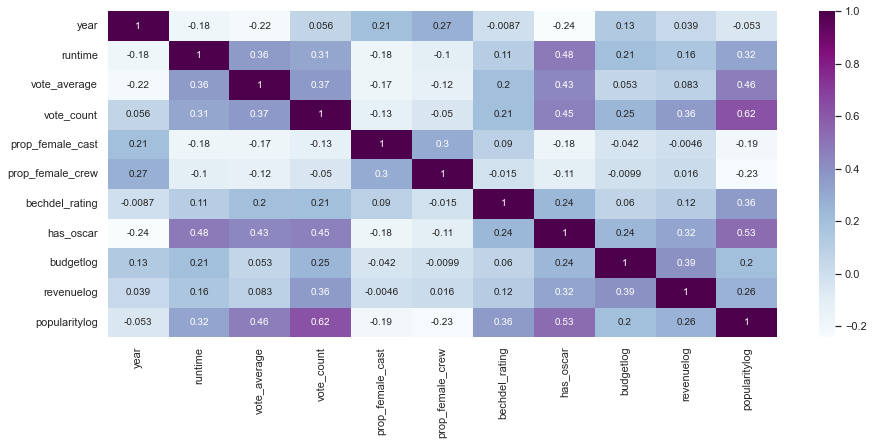

In [72]:
corr=film_data.corr() # produces correlation values
plt.figure(figsize=(15,6))
sns.heatmap(corr, annot = True, cmap="BuPu")  # visualising the correlation matrix
plt.show()

In [73]:
X = film_data.drop(['has_oscar'],axis=1) #separating the data into target variable and remaining features
y = film_data['has_oscar']

In [74]:
#for each method, instantiating select k best then creating a series for plotting
chi2 = SelectKBest(score_func = chi2, k = 'all').fit(X,y)
chi2_sorted = pd.Series(data=chi2.scores_, index=X.columns).sort_values() 

ftest = SelectKBest(score_func = f_classif, k = 'all').fit(X,y)
ftest_sorted = pd.Series(data=ftest.scores_, index=X.columns).sort_values()

mitest = SelectKBest(score_func = mutual_info_classif, k = 'all').fit(X,y)
mitest_sorted = pd.Series(data=mitest.scores_, index=X.columns).sort_values()

In [75]:
# using extra trees to generate an additional mutual information score

xtrees = ExtraTreesClassifier().fit(X, y)
xtrees_sorted = pd.Series(data=xtrees.feature_importances_, index=X.columns).sort_values()

muinfo = mutual_info_classif(X,y)
muinfo_sorted = pd.Series(data=muinfo, index=X.columns).sort_values()

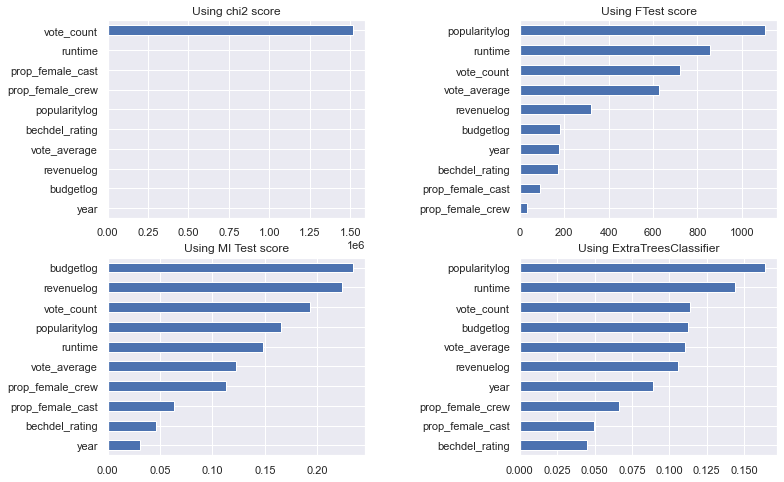

In [76]:
#plotting out the scores from select k best and extra trees

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8)) 
plt.subplots_adjust(wspace=0.6)
chi2_sorted.plot(kind='barh', ax=axes[0, 0], title='Using chi2 score')
ftest_sorted.plot(kind='barh', ax=axes[0, 1], title='Using FTest score')
xtrees_sorted.plot(kind='barh', ax=axes[1, 1], title='Using ExtraTreesClassifier')
mitest_sorted.plot(kind='barh', ax=axes[1, 0], title='Using MI Test score')
plt.show()

## Prediction and Evaluation

In [77]:
def train_and_evaluate(model, X, y):
    """
        Train and evaluate a classification model on training data
        and produce accuracy metrics for a separate test set.
    """

    print('\nResults from algorithm {}:'.format(model))

    # Split data into train and test 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Cross-validation 
    
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
    print('Mean cross-validation accuracy is {:.3f} with SD {:.3f}'
          .format(np.mean(scores), np.std(scores)))

    # Fit model

    learnt_model = model.fit(X_train, y_train)
    print('\nAccuracy on training data is {:.3f}\n'.format(model.score(X_train, y_train)))
    
    
    # Predicting target values from test feature variables
    # then computing evaluation metrics relevant to binary outcome variable

    y_pred = model.predict(X_test)
    print('Test data metrics: accuracy={:.3f}, f1={:.3f}, precision={:.3f}, recall={:.3f}'
          .format(accuracy_score(y_true=y_test, y_pred=y_pred),
                  f1_score(y_true=y_test, y_pred=y_pred),
                  precision_score(y_true=y_test, y_pred=y_pred),
                  recall_score(y_true=y_test, y_pred=y_pred)))
    
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
    plt.figure(figsize=(3, 3))
    ax = sns.heatmap(cm,annot=True, xticklabels=['N','Y'], cbar=False,
                     yticklabels=['N','Y'], square=True,
                     linewidths=8.0) # plots the confusion matrix
    ax.set_xlabel('Predicted Oscar Status')
    ax.set_ylabel('Actual Oscar Status')
    plt.show()
    
    return learnt_model


Results from algorithm KNeighborsClassifier(metric='manhattan', n_neighbors=7):
Mean cross-validation accuracy is 0.847 with SD 0.021

Accuracy on training data is 0.882

Test data metrics: accuracy=0.847, f1=0.699, precision=0.763, recall=0.645


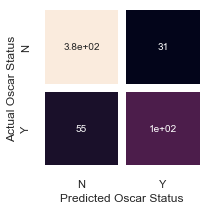

In [78]:
_ = train_and_evaluate(KNeighborsClassifier(n_neighbors=7,metric='manhattan'), X, y)


Results from algorithm LogisticRegression(C=0.85, max_iter=200):
Mean cross-validation accuracy is 0.875 with SD 0.018

Accuracy on training data is 0.877

Test data metrics: accuracy=0.877, f1=0.758, precision=0.831, recall=0.697


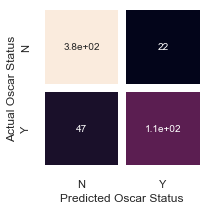

In [79]:
_ = train_and_evaluate(LogisticRegression(C=0.85,max_iter=200), X, y)

## Using cross-validation to select hyperparameters


In [80]:
def train_model(algorithm, hyperparams, X, y):
    """
        Use cross-validation to determine model accuracy for a 
        specified algorithm, hyperparameters, features and target
        variables.
        
        :param Scikit-Learn class algorithm: name of constructor for algorithm
        :param dict hyperparameters: hyperparameters passed to constructor- keys must 
                                     be parameters allowed for constructor
        :param array-like X: values of feature variables
        :param vector-like y: values of target variables
        
        :returns tuple: mean accuracy across all CV folds, and trained model
    """
    # Instantiate the specified model using the specified hyperparameter values

    model = algorithm(**hyperparams)

    # Perform cross-validation
    
    scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')

    # Fit model

    learnt_model = model.fit(X, y)

    # return mean accuracy over all CV folds

    return (np.mean(scores), learnt_model)

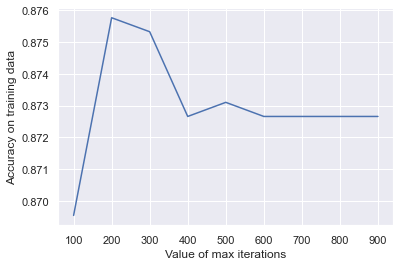

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# testing a range of max iterations

iter_values = [i for i in range(100,1000,100)]
iter_accuracy = []
for number_iter in iter_values:
    acc, _ = train_model(LogisticRegression, {'max_iter': number_iter}, X_train, y_train)
    iter_accuracy.append(acc)

# Plot the results

plt.plot(iter_values, iter_accuracy) 
plt.ylabel('Accuracy on training data')
plt.xlabel('Value of max iterations')
plt.show()

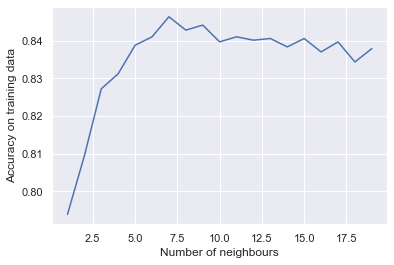

In [82]:
# testing different numbers for k 

neighbours_values = [i for i in range(1,20)]
neighbours_accuracy = []
for number_neighbours in neighbours_values:
    acc, _ = train_model(KNeighborsClassifier, {'n_neighbors': number_neighbours}, X_train, y_train)
    neighbours_accuracy.append(acc)

# Plot the results

plt.plot(neighbours_values, neighbours_accuracy)
plt.ylabel('Accuracy on training data')
plt.xlabel('Number of neighbours')
plt.show()

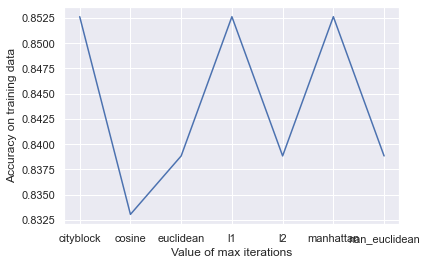

In [83]:

# trying a range of distance metrics

distance_values = ['cityblock','cosine','euclidean','l1','l2','manhattan','nan_euclidean']
distance_accuracy = []
for distance_type in distance_values:
    acc, _ = train_model(KNeighborsClassifier, {'metric': distance_type}, X_train, y_train)
    distance_accuracy.append(acc)

# Plot the results

plt.plot(distance_values, distance_accuracy) 
plt.ylabel('Accuracy on training data')
plt.xlabel('Value of max iterations')
plt.show()

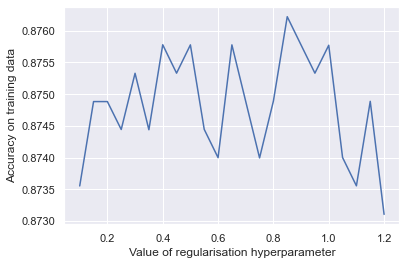

In [84]:
#trying a range of regularisation strengths

reg_values = [0.05 * i for i in range(2, 25)]
reg_accuracy = []
for reg_strength in reg_values:
    acc, _ = train_model(LogisticRegression, {'C': reg_strength,'max_iter':200}, X_train, y_train)
    reg_accuracy.append(acc)

# Plot the results

plt.plot(reg_values, reg_accuracy) 
plt.ylabel('Accuracy on training data')
plt.xlabel('Value of regularisation hyperparameter')
plt.show()

## Showing how the model performed with imbalanced data

In [85]:
initial_data['budgetlog'] = np.log(initial_data['budget'])
initial_data['revenuelog'] = np.log(initial_data['revenue'])
initial_data['popularity'] = np.where((initial_data['popularity']<1),1,initial_data['popularity'])
initial_data['popularitylog'] = np.log(initial_data['popularity'])

In [86]:
initial_data.drop(columns=['budget','popularity','revenue','title'],inplace=True)

In [87]:
X_1 = initial_data.drop(['has_oscar'],axis=1)
y_1 = initial_data['has_oscar']


Results from algorithm KNeighborsClassifier(metric='manhattan', n_neighbors=7):
Mean cross-validation accuracy is 0.837 with SD 0.018

Accuracy on training data is 0.869

Test data metrics: accuracy=0.837, f1=0.394, precision=0.718, recall=0.271


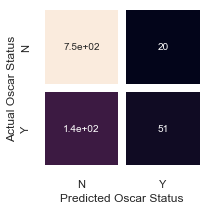

In [88]:
_ = train_and_evaluate(KNeighborsClassifier(n_neighbors=7,metric='manhattan'), X_1, y_1)